In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import math
import scipy
np.random.seed()

# Open loop Model 

In the following cell, we define the model that will be used throught the project. We use the equations derived in the report to simulate the trajectories. The parameters of the function correspond to the 4 parameters of movement $\beta, \epsilon, \gamma, \sigma$, plus the initial and final conditions of the problem, with could be tweaked, as well as some control variables for testing, and the timestep, which could be varied according tho necessity. It was left at $500$ fps because with lower frequencies the model became too coarse and integration errors overtook the model.

In [2]:
def modelSimulation(in_con=(0,0,0,0), x_T=1., x_1=.2, sigma=.5, beta=.5, epsilon=.5, gamma=.5,
                    timestep=1./500, angle=math.pi*7/24, angle0=0, p=(.2,0), r=.1,
                    initial_control=[ 3.04624830e+00, -1.56797070e-01,  5.48092996e-01,  6.52857202e-01, -6.97473103e+00,  6.86269834e-03],
                    Arc=True, Brownian=True):
    
    x,v,y,w = in_con
    
    x_Story=[]
    v_Story=[]
    y_Story=[]
    w_Story=[]
    
    ux_Story=[]
    uy_Story=[]
    
    l=x_T-x
    i=0
    t=0.
    Wt=0.
    lambda2, lambda4, lambda1, lambda3,l1,l3=initial_control
    
    while(i<2 or (x<x_T and i<1000)):
            
        t=i*timestep
        
        if(x>x_1):
            lambda1, lambda3=l1,l3
        
        if(Brownian == True):
            W_increment=np.random.normal(0.,np.sqrt(timestep),1)[0]
        else:
            W_increment=1.
            
        Wt=Wt+W_increment
        
        #lambda1=lambda1+timestep*0
        if(i>2 and np.linalg.norm(x-x_T)<timestep*v):
            lambda3=lambda3+timestep*(-2*y)
        
        lambda2=lambda2+timestep*lambda1
        ux=epsilon*l/(1-gamma)*lambda2*math.e**(t/beta)
        lambda4=lambda4+timestep*lambda3
        uy=epsilon*l/(gamma)*lambda3*math.e**(t/beta)
#         ux=ux+timestep*l/(1-gamma)*lambda1
#         uy=uy+timestep*l/(gamma)*lambda3
        
        v=v+timestep*ux
        w=w+timestep*uy
        
        x=x+timestep*v
        y=y+timestep*(w+ux**2*sigma*W_increment)
        #We record the story
        if(Arc):
            x_Story.append((1+y)*np.cos(angle*(x/x_T-1)+angle0))
            y_Story.append((1+y)*np.sin(angle*(x/x_T-1)+angle0))
        else:
            x_Story.append(x)
            y_Story.append(y)
        v_Story.append(v)
        w_Story.append(w)
        ux_Story.append(ux)
        uy_Story.append(uy)
        
        i=i+1
    if(i==1000):
        t=1000
    return np.array(x_Story), np.array(v_Story), np.array(ux_Story),\
            np.array(y_Story), np.array(w_Story), np.array(uy_Story), t

# Shooting method

Here, we use the shooting method to find the optimal path, which is described the varaibles stored in initial_control

In [ ]:
beta=.5
epsilon=.1
gamma=.5
timestep=1/500

def arc_length(x, y):
    npts = len(x)
    arc = np.sqrt((x[1] - x[0])**2 + (y[1] - y[0])**2)
    for k in range(1, npts):
        arc = arc + np.sqrt((x[k] - x[k-1])**2 + (y[k] - y[k-1])**2)

    return arc

def fun2 (parameters):
    
    x,v,ux,y,w,uy,T=modelSimulation(in_con=(0,0,0,0), x_T=1., x_1=.2, sigma=0, 
                                    beta=beta, epsilon=epsilon, gamma=gamma,
                    timestep=timestep, angle=math.pi*7/24, p=(.2,0), r=.1,
                    initial_control=parameters,
                    Arc=True, Brownian=False)
    
    trange=np.linspace(0, len(ux)*timestep, num=len(ux))
    force=((1-gamma)*ux**2+gamma*uy**2)*math.e**(trange/beta)/(2*arc_length(x,y))
    integral=(force[1:]+force[:-1]).sum()*T/(2*(len(ux)-1))
    J=(1-(1-x[-1])**2)*math.e**(-T/beta)-epsilon*integral
    return -J

res2=scipy.optimize.minimize(fun2, ( 3.7, -0.15679707,  0.97252444,  0.54660283, -6.75775885, -0.06253371), args=(), method=None)
res2.x, fun2(res2.x)

# Model Visualization

Here we can visualize the trajectories produced by the control variables we obtained. When plotting hundreds of trajectories, we can observe the effects of randomness to better detail

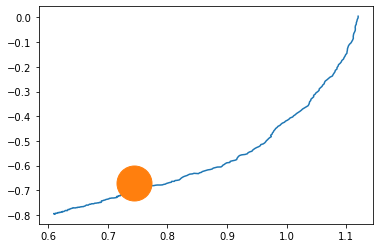

In [10]:
x,v,ux,y,w,uy,T=modelSimulation(initial_control=res2.x)
plt.plot(x,y)
angle=math.pi*7/24
T_1=.2
plt.plot(np.cos(angle*(T_1-1)),np.sin(angle*(T_1-1)),marker='o',markersize=35)
plt.show()

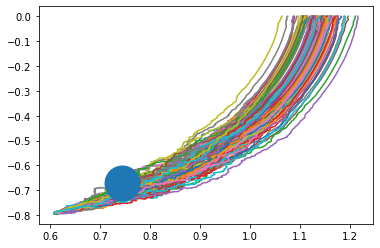

In [11]:
for i in range(100):
    x,v,ux,y,w,uy,T=modelSimulation(initial_control=res2.x,sigma=5,
                                    beta=beta, epsilon=epsilon, gamma=gamma)
    plt.plot(x,y)
angle=math.pi*7/24
T_1=.2
plt.plot(np.cos(angle*(T_1-1)),np.sin(angle*(T_1-1)),marker='o',markersize=35)
plt.show()

# Other approaches

In the following cells, there is another model we considered, based on Kalman Filtering. Such models lead to more regular and better controlled trajectories, so we considered it for this reasons. Ultimately, the previous model proved more resilient in our context, and easier to train for parameters, so we took that approach.

Later, there is an analytically integrated model based on initial explorations of the model. As the complexity of the model has grown, analytical solutions have disappeared, in favor of the current simulation model.

These models are left for reference, but are not tested for compatibility with final data.

## Kalman filter Model 

In [7]:
res2.x, fun2(res2.x)

(array([ 3.99818474, -0.15679707,  0.97252444,  0.54660283, -6.75775885,
        -0.06253371]),
 8.519292551483268e-15)

In [8]:
def KalmanSimulation(in_con=(0,0,0,0), x_T=1., T=1., T_1=.2, sigma=1, alpha=.5, epsilon=.5, gamma=.5,
                    step=500, angle=math.pi*7/24, p=(.2,0), r=.1, Arc=True):
    
    x,v,y,w = in_con
    
    x_Story=[]
    v_Story=[]
    y_Story=[]
    w_Story=[]
    
    timestep=T/step
    l=x_T-x
    i=0
    Wt=0.
    
    ux, uy, lambda1, lambda3,l1,l3=res2.x
    
    Xp=np.array([x,v,ux,lambda1,y,w,uy,lambda3])
    Pp=np.zeros((8,8))
    
    Q=np.zeros((8,8))
    
    H=np.zeros(8)
    H[4]=1.
    
    M=np.zeros((8,8))
    for j in range(8):
        M[j][j]=1.

    for j in range(7):
        M[j][j+1]=timestep
    M[3][4]=0
    M[2][3]=l/(1-gamma)*timestep
    M[6][7]=l/(gamma)*timestep
    
    while(i<=step):
        
        if(i>=step*T_1):
            Xp[3]=l1
            Xp[7]=l3
        
        Q[4][4]=timestep*alpha*sigma*ux**2
        
        omega=timestep*alpha*ux**2*sigma*np.random.normal(0.,np.sqrt(timestep),1)
        
        Xm=np.dot(M,Xp)
        Pm=np.dot(np.dot(M,Pp),M.T)+Q
        
        K=np.dot(Pm,H)/(np.dot(H,np.dot(Pm,H))+timestep*alpha*sigma*ux**2)
        Xp=Xm+K*(omega)
        #print(i,K[4], omega)
        Pp=np.dot(np.identity(8)-np.outer(K,H),Pm)        
        
        x,v,ux,lambda1,y,w,uy,lambda3=Xp
        
        #We record the story
        if(Arc):
            x_Story.append((1+y)*np.cos(angle*(x/x_T-1)))
            y_Story.append((1+y)*np.sin(angle*(x/x_T-1)))
        else:
            x_Story.append(x)
            y_Story.append(y)
        v_Story.append(v)
        w_Story.append(w)
        
        i=i+1
        
    return x_Story, v_Story ,y_Story, w_Story

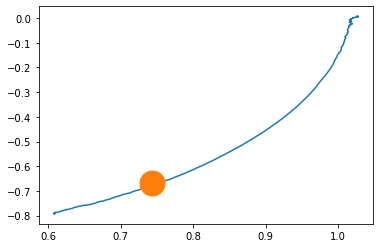

In [9]:
x,v,y,w=KalmanSimulation()
plt.plot(x,y)
angle=math.pi*7/24
T_1=.2
plt.plot(np.cos(angle*(T_1-1)),np.sin(angle*(T_1-1)),marker='o',markersize=25)
plt.show()

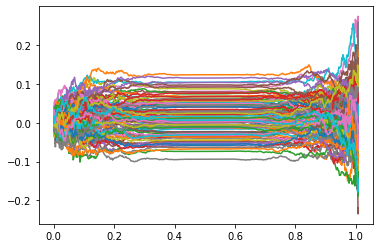

In [10]:
for i in range(100):
    x,v,y,w=KalmanSimulation(sigma=10,Arc=False)
    plt.plot(x,y)
angle=math.pi*7/24
T_1=.2
# plt.plot(np.cos(angle*(T_1-1)),np.sin(angle*(T_1-1)),marker='o',markersize=25)
plt.show()

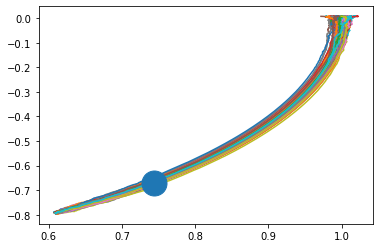

In [11]:
for i in range(100):
    x,v,y,w=KalmanSimulation()
    plt.plot(x,y)
angle=math.pi*7/24
T_1=.2
plt.plot(np.cos(angle*(T_1-1)),np.sin(angle*(T_1-1)),marker='o',markersize=25)
plt.show()

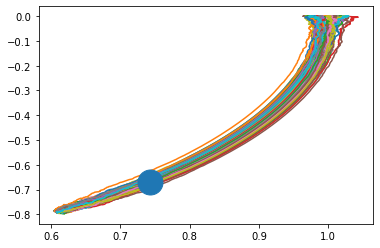

In [97]:
for i in range(100):
    x,v,y,w=modelSimulation()
    plt.plot(x,y)
angle=math.pi*7/24
T_1=.2
plt.plot(np.cos(angle*(T_1-1)),np.sin(angle*(T_1-1)),marker='o',markersize=25)
plt.show()

## Model integration

In [2]:
def u1(t, T=1., x_T=1., sigma=1., alpha=.5, epsilon=.5, gamma=.5):
    return 6*x_T/T**3*(T-2*t)

def u2(t, T=1., x_T=1., sigma=1., alpha=.5, epsilon=.5, gamma=.5):
    return x_T/6./T**3*(T/3-t)

def dy(t, W_increment, T=1., T_1=.5, x_T=1., sigma=1., alpha=.5, epsilon=.5, gamma=.5):
    return alpha*u1(t,T_1,x_T,sigma,alpha,epsilon,gamma)**2*sigma*W_increment
    
def modelSimulation(in_con=(0,0,0,0), x_T0=1., T=1., T_1=.2, sigma=1, alpha=.5, epsilon=.5, gamma=.5,
                    step=500, angle=math.pi*7/24, p=(.2,0), r=.1):
    
    x,v,y,w = in_con
    
    x_Story=[]
    v_Story=[]
    y_Story=[]
    w_Story=[]
    
    timestep=T/step
    i=0
    t=0.
    Wt=0.
    
    x_T=x_T0-p[0]/2.
    while(i<=step):
            
        t=i*timestep
        
        if(x>p[0]):
            x_T=x_T0-p[0]
        
        W_increment=np.random.normal(0.,np.sqrt(timestep),1)
        Wt=Wt+W_increment

        v=v+timestep*u1(t,T,x_T,sigma,alpha,epsilon,gamma)
        w=w+timestep*u2(t,T,x_T,sigma,alpha,epsilon,gamma)
        
        x=x+timestep*v

        y=y+timestep*(w+dy(t,W_increment,T,x_T,sigma,alpha,epsilon,gamma))
        
        #We record the story
        x_Story.append((1+y)*np.cos(angle*(x/x_T-1)))
        y_Story.append((1+y)*np.sin(angle*(x/x_T-1)))
#         x_Story.append(x)
#         y_Story.append(y)
        v_Story.append(v)
        w_Story.append(w)
        
        i=i+1
        
    return x_Story, v_Story ,y_Story, w_Story

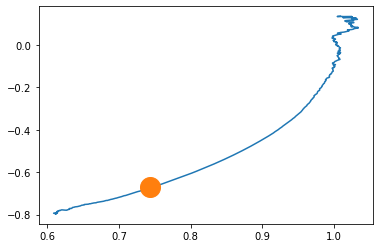

In [3]:
x,v,y,w=modelSimulation()
plt.plot(x,y)
angle=math.pi*7/24
T_1=.2
plt.plot(np.cos(angle*(T_1-1)),np.sin(angle*(T_1-1)),marker='o',markersize=20)
plt.show()

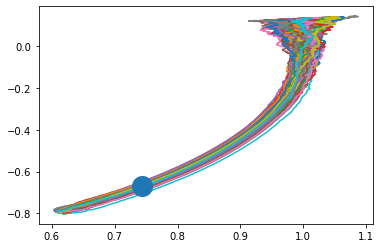

In [4]:
for i in range(100):
    x,v,y,w=modelSimulation()
    plt.plot(x,y)
angle=math.pi*7/24
T_1=.2
plt.plot(np.cos(angle*(T_1-1)),np.sin(angle*(T_1-1)),marker='o',markersize=20)
plt.show()